## Цель : 
### Прогнозирование временных рядов методом скользящего окна.

In [18]:
import warnings
warnings.filterwarnings('ignore')

from pandas import DataFrame
from pandas import concat
import pandas as pd
import numpy as np
import scipy.stats as scs
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, mean_squared_error
from random import randint

import matplotlib.pyplot as plt
%matplotlib inline

from fbprophet import Prophet

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import graph_objs as go

import xgboost
import xgboost as xgb
from xgboost import XGBRegressor
 
from sklearn.experimental import enable_hist_gradient_boosting

from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_columns', 120)
pd.set_option('display.max_rows', 1240)
pd.set_option('display.width', 180)


In [19]:
pd.read_csv('EURUSD1.csv')

,2016.05.26,04:38,1.11709,1.11713,1.11698,1.11699,60
0,2016.05.26,04:39,1.11700,1.11700,1.11683,1.11685,63
1,2016.05.26,04:40,1.11685,1.11691,1.11681,1.11690,63
2,2016.05.26,04:41,1.11689,1.11690,1.11683,1.11689,37
3,2016.05.26,04:42,1.11688,1.11690,1.11684,1.11684,34
4,2016.05.26,04:43,1.11684,1.11685,1.11665,1.11665,53
...,...,...,...,...,...,...,...
999995,2019.02.01,23:54,1.14537,1.14537,1.14534,1.14536,32
999996,2019.02.01,23:55,1.14536,1.14537,1.14528,1.14530,49
999997,2019.02.01,23:56,1.14531,1.14533,1.14521,1.14529,57
999998,2019.02.01,23:57,1.14525,1.14536,1.14525,1.14531,52


In [20]:
df_eu = pd.read_csv('EURUSD1.csv', usecols=[0,1,5],
                 names=['Date','Time', 'Close'], 
                 parse_dates = [['Date', 'Time']],
                 index_col=['Date_Time'], 
                )

In [21]:
df_eu

,Close
Date_Time,
2016-05-26 04:38:00,1.11699
2016-05-26 04:39:00,1.11685
2016-05-26 04:40:00,1.11690
2016-05-26 04:41:00,1.11689
2016-05-26 04:42:00,1.11684
...,...
2019-02-01 23:54:00,1.14536
2019-02-01 23:55:00,1.14530
2019-02-01 23:56:00,1.14529


In [22]:
df_eu.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1000001 entries, 2016-05-26 04:38:00 to 2019-02-05 15:50:00
Data columns (total 1 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   Close   1000001 non-null  float64
dtypes: float64(1)
memory usage: 15.3 MB


In [23]:
# оставим по значения часам
df = df_eu.copy()
df ['y']= df_eu[['Close']].resample('H').last()
df.dropna(inplace=True)
df = df.drop(['Close'],axis=1)
df

,y
Date_Time,
2016-05-26 05:00:00,1.11751
2016-05-26 06:00:00,1.11806
2016-05-26 07:00:00,1.11794
2016-05-26 08:00:00,1.11831
2016-05-26 09:00:00,1.11704
...,...
2019-02-01 19:00:00,1.14683
2019-02-01 20:00:00,1.14597
2019-02-01 21:00:00,1.14593


In [24]:
# функция создающая df с лагами порядка lag_in - до времени t(прошлое), - обучение.
# lag_out - после времени t(будущее) - то, что нужно предсказать
#lag(n) = y(t(0)) - y(t(n))
# dropnan - удаление строчек с NaN

def fun_lag(data, lag_in=1, lag_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    for i in range(lag_in, 0, -1):
        cols.append(df.shift(i) - df.shift(0) )
        names += [('lag%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    for i in range(0, lag_out+1):
        if i == 0:
            names += [('y_%d(t)' % (j+1)) for j in range(n_vars)]
            cols.append(df.shift(-i))
        else:
            cols.append(df.shift(-i) - df.shift(0))
            names += [('lag%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    df_lag = concat(cols, axis=1)
    df_lag.columns = names
    if dropnan:
        df_lag.dropna(inplace=True)
    return df_lag


In [25]:
# Пример того, что делает функция fun_lag на последовательности чисел#
# без удаления NaN, для понимания принципа построения
vind = [x*x for x in range(10)]
df_vind = pd.DataFrame(vind, columns=['y']) 
df_sample = fun_lag(df_vind, 4, 4, False)
df_sample[:10]

,lag1(t-4),lag1(t-3),lag1(t-2),lag1(t-1),y_1(t),lag1(t+1),lag1(t+2),lag1(t+3),lag1(t+4)
0,NaN,NaN,NaN,NaN,0,1.0,4.0,9.0,16.0
1,NaN,NaN,NaN,-1.0,1,3.0,8.0,15.0,24.0
2,NaN,NaN,-4.0,-3.0,4,5.0,12.0,21.0,32.0
3,NaN,-9.0,-8.0,-5.0,9,7.0,16.0,27.0,40.0
4,-16.0,-15.0,-12.0,-7.0,16,9.0,20.0,33.0,48.0
5,-24.0,-21.0,-16.0,-9.0,25,11.0,24.0,39.0,56.0
6,-32.0,-27.0,-20.0,-11.0,36,13.0,28.0,45.0,NaN
7,-40.0,-33.0,-24.0,-13.0,49,15.0,32.0,NaN,NaN
8,-48.0,-39.0,-28.0,-15.0,64,17.0,NaN,NaN,NaN
9,-56.0,-45.0,-32.0,-17.0,81,NaN,NaN,NaN,NaN


In [26]:
# с удалением строк с NaN
vind = [x*x for x in range(10)]
df_vind = pd.DataFrame(vind, columns=['y'])
df_sample = fun_lag(df_vind, 4)
df_sample[:10]

,lag1(t-4),lag1(t-3),lag1(t-2),lag1(t-1),y_1(t),lag1(t+1)
4,-16.0,-15.0,-12.0,-7.0,16,9.0
5,-24.0,-21.0,-16.0,-9.0,25,11.0
6,-32.0,-27.0,-20.0,-11.0,36,13.0
7,-40.0,-33.0,-24.0,-13.0,49,15.0
8,-48.0,-39.0,-28.0,-15.0,64,17.0


In [27]:
test_size=0.25
size = int(df.shape[0]*(1-test_size))
df_train = df.iloc[:size]
df_test = df.iloc[size:]

In [28]:
df_train.shape

(12486, 1)

In [29]:
df_test.shape

(4163, 1)

In [30]:
lag_in=30 # колтчество лагов

df_train_data = fun_lag(df_train[['y']], lag_in)
y_train_data = df_train_data['lag1(t+1)']
X_train_data = df_train_data.drop(['y_1(t)','lag1(t+1)'], axis=1)

df_test_data = fun_lag(df_test[['y']], lag_in)
y_test_data = df_test_data['lag1(t+1)']
X_test_data = df_test_data.drop(['y_1(t)','lag1(t+1)'], axis=1)

In [31]:
df_train_data[:3]

,lag1(t-30),lag1(t-29),lag1(t-28),lag1(t-27),lag1(t-26),lag1(t-25),lag1(t-24),lag1(t-23),lag1(t-22),lag1(t-21),lag1(t-20),lag1(t-19),lag1(t-18),lag1(t-17),lag1(t-16),lag1(t-15),lag1(t-14),lag1(t-13),lag1(t-12),lag1(t-11),lag1(t-10),lag1(t-9),lag1(t-8),lag1(t-7),lag1(t-6),lag1(t-5),lag1(t-4),lag1(t-3),lag1(t-2),lag1(t-1),y_1(t),lag1(t+1)
Date_Time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-05-27 11:00:00,-0.00054,0.00001,-0.00011,0.00026,-0.00101,-0.00111,-0.00029,0.00023,-0.00014,-0.00105,0.00193,0.00163,0.00032,0.00023,-0.00055,0.00014,0.00101,0.00073,0.00128,0.00113,0.00117,0.00106,0.00107,0.00097,0.00045,0.00071,0.00076,0.00082,0.00093,-0.00052,1.11805,-0.00032
2016-05-27 12:00:00,0.00033,0.00021,0.00058,-0.00069,-0.00079,0.00003,0.00055,0.00018,-0.00073,0.00225,0.00195,0.00064,0.00055,-0.00023,0.00046,0.00133,0.00105,0.00160,0.00145,0.00149,0.00138,0.00139,0.00129,0.00077,0.00103,0.00108,0.00114,0.00125,-0.00020,0.00032,1.11773,-0.00008
2016-05-27 13:00:00,0.00029,0.00066,-0.00061,-0.00071,0.00011,0.00063,0.00026,-0.00065,0.00233,0.00203,0.00072,0.00063,-0.00015,0.00054,0.00141,0.00113,0.00168,0.00153,0.00157,0.00146,0.00147,0.00137,0.00085,0.00111,0.00116,0.00122,0.00133,-0.00012,0.00040,0.00008,1.11765,-0.00118


In [32]:
X_train_data[:3]

,lag1(t-30),lag1(t-29),lag1(t-28),lag1(t-27),lag1(t-26),lag1(t-25),lag1(t-24),lag1(t-23),lag1(t-22),lag1(t-21),lag1(t-20),lag1(t-19),lag1(t-18),lag1(t-17),lag1(t-16),lag1(t-15),lag1(t-14),lag1(t-13),lag1(t-12),lag1(t-11),lag1(t-10),lag1(t-9),lag1(t-8),lag1(t-7),lag1(t-6),lag1(t-5),lag1(t-4),lag1(t-3),lag1(t-2),lag1(t-1)
Date_Time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-05-27 11:00:00,-0.00054,0.00001,-0.00011,0.00026,-0.00101,-0.00111,-0.00029,0.00023,-0.00014,-0.00105,0.00193,0.00163,0.00032,0.00023,-0.00055,0.00014,0.00101,0.00073,0.00128,0.00113,0.00117,0.00106,0.00107,0.00097,0.00045,0.00071,0.00076,0.00082,0.00093,-0.00052
2016-05-27 12:00:00,0.00033,0.00021,0.00058,-0.00069,-0.00079,0.00003,0.00055,0.00018,-0.00073,0.00225,0.00195,0.00064,0.00055,-0.00023,0.00046,0.00133,0.00105,0.00160,0.00145,0.00149,0.00138,0.00139,0.00129,0.00077,0.00103,0.00108,0.00114,0.00125,-0.00020,0.00032
2016-05-27 13:00:00,0.00029,0.00066,-0.00061,-0.00071,0.00011,0.00063,0.00026,-0.00065,0.00233,0.00203,0.00072,0.00063,-0.00015,0.00054,0.00141,0.00113,0.00168,0.00153,0.00157,0.00146,0.00147,0.00137,0.00085,0.00111,0.00116,0.00122,0.00133,-0.00012,0.00040,0.00008


In [33]:
# X_train_data.values[:3]

In [34]:
y_train_data[:3]

Date_Time
2016-05-27 11:00:00   -0.00032
2016-05-27 12:00:00   -0.00008
2016-05-27 13:00:00   -0.00118
Name: lag1(t+1), dtype: float64

In [35]:
df_test_data[['lag1(t+1)']][:5]

,lag1(t+1)
Date_Time,
2018-06-01 21:00:00,-0.00079
2018-06-01 22:00:00,0.00021
2018-06-01 23:00:00,0.00061
2018-06-04 00:00:00,-0.00011
2018-06-04 01:00:00,0.00050


In [36]:
# plotly_df(df_test_data[['lag1(t+1)']][:100])

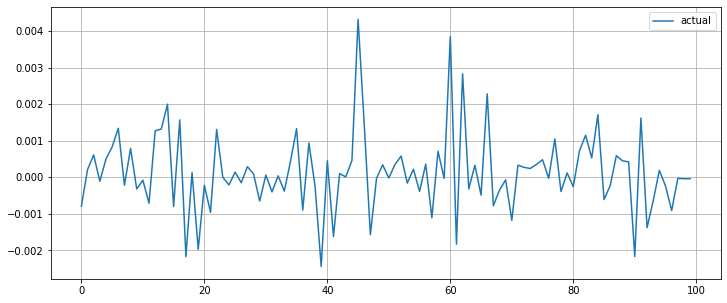

In [37]:
plt.figure(figsize=(12, 5))
plt.plot(y_test_data.values[:100], label="actual")
plt.legend(loc="best")
plt.grid(True);

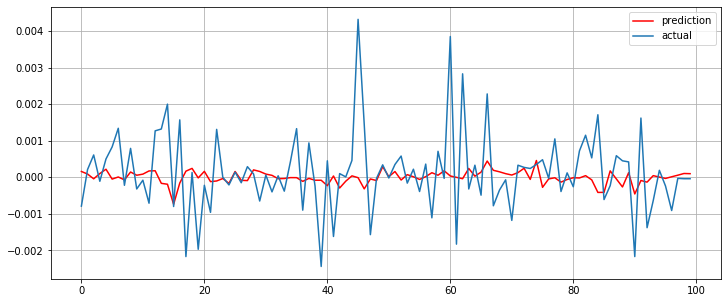

In [38]:
# применение разных моделей в базовых настройках
# меняя # можно посмотреть разные модели, HistGradientBoostingRegressor - более менее, на фоне остальных

# model = ExtraTreesRegressor(random_state=0)
model = HistGradientBoostingRegressor(random_state=0)
# model = xgboost.XGBRegressor(random_state=0)
# model = RandomForestRegressor(random_state=0)
# model = LinearRegression(random_state=0)

model.fit(X_train_data, y_train_data)
prediction = model.predict(X_test_data)

plt.figure(figsize=(12, 5))
plt.plot(prediction[:100], 'r', label="prediction")
plt.plot(y_test_data.values[:100], label="actual")
plt.legend(loc="best")
plt.grid(True);

Разные модели показали схожий график предсказаний:
прогноз изменнеий на много меньше реального и явно не предсказывает предстоящие изменения цены.

### Вывод по обучению по схеме разделения X_train -  X_test:
классический подход показал, что модель обученная на большом количестве данных осторожно делает прогноз, и полагаться на это пресказание не имеет особого смысла

# Обучение скользящим окном.

Дополним имеющиеся функции следующим:
- обучение будет происходить на ограниченном количестве строк (в примере - 20)
- количество лагов оставим 30
- X_train - это движущиеся окно размером 20 строк * 30 лагов, 
- y_train - это движущиеся окно lag1(t+1) для каждой строки. 
- X_test - это движущаяся 21-я строка из лагов,
- y_test - это lag1(t+1) для 21-ой строки,



In [41]:
# функция создающая df с лагами порядка lag_in - до времени t(прошлое), - обучение.
# lag_out - после времени t(будущее) - то, что нужно предсказать
# delta(n) = y(t(n)) - y(t(n - 1))
# dropnan - удаление строчек с NaN

def fun_delta(data, delta_in=1, delta_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    for i in range(delta_in, 0, -1):
#         cols.append(df.shift(i) - df.shift(0))
        cols.append(df.shift(i+1) - df.shift(i))
        names += [('delta%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    for i in range(0, delta_out+1):
        if i == 0:
            names += [('y_%d(t)' % (j+1)) for j in range(n_vars)]
            cols.append(df.shift(-i))
        else:
            cols.append(df.shift(-i) - df.shift(-i+1))
#             cols.append(df.shift(-i) - df.shift(0))
            names += [('delta%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    df_delta = concat(cols, axis=1)
    df_delta.columns = names
    if dropnan:
        df_delta.dropna(inplace=True)
    return df_delta


In [42]:
# Пример того, что делает функция fun_delta на последовательности чисел
# без удаления NaN, для понимания принципа построения
vind = [x*x for x in range(10)]
df_vind = pd.DataFrame(vind, columns=['y']) 
df_sample = fun_delta(df_vind, 4, 4, False)
df_sample[:10]

,delta1(t-4),delta1(t-3),delta1(t-2),delta1(t-1),y_1(t),delta1(t+1),delta1(t+2),delta1(t+3),delta1(t+4)
0,NaN,NaN,NaN,NaN,0,1.0,3.0,5.0,7.0
1,NaN,NaN,NaN,NaN,1,3.0,5.0,7.0,9.0
2,NaN,NaN,NaN,-1.0,4,5.0,7.0,9.0,11.0
3,NaN,NaN,-1.0,-3.0,9,7.0,9.0,11.0,13.0
4,NaN,-1.0,-3.0,-5.0,16,9.0,11.0,13.0,15.0
5,-1.0,-3.0,-5.0,-7.0,25,11.0,13.0,15.0,17.0
6,-3.0,-5.0,-7.0,-9.0,36,13.0,15.0,17.0,NaN
7,-5.0,-7.0,-9.0,-11.0,49,15.0,17.0,NaN,NaN
8,-7.0,-9.0,-11.0,-13.0,64,17.0,NaN,NaN,NaN
9,-9.0,-11.0,-13.0,-15.0,81,NaN,NaN,NaN,NaN


In [43]:
# с удалением строк с NaN
vind = [x*x for x in range(10)]
df_vind = pd.DataFrame(vind, columns=['y'])
df_sample = fun_delta(df_vind, 4)
df_sample[:10]

,delta1(t-4),delta1(t-3),delta1(t-2),delta1(t-1),y_1(t),delta1(t+1)
5,-1.0,-3.0,-5.0,-7.0,25,11.0
6,-3.0,-5.0,-7.0,-9.0,36,13.0
7,-5.0,-7.0,-9.0,-11.0,49,15.0
8,-7.0,-9.0,-11.0,-13.0,64,17.0


In [46]:
# fun_slick - функция предсказаний скользящим окном 

n_rows = 2 # - число сток обучения
n_max = 50 # - ограничение расстояния движения окна предсказаний, т.к - каждое предсказание - новое обучение

def fun_slick(df_sample, model=LinearRegression(), n_rows=2, n_max = 50):
    y_vind = df_sample['delta1(t+1)']
    X_vind = df_sample.drop(['y_1(t)','delta1(t+1)'], axis=1)
    pred_dict = []
    for i in range(len(X_vind)):
        if i < n_max: #< len(X_vind) - n_rows:
            i_r =  i + n_rows
            lr_fit = model.fit(X_vind.iloc[i:i_r], y_vind[i:i_r]),
            pred = model.predict(X_vind.iloc[i_r : i_r + 1])
            pred_dict.append(pred[0])
        else:
            break
#     pred_dict = np.array([pred_dict])
    y_dict = y_vind[n_rows:n_max+n_rows].values
# print(y_dict)
    return  pred_dict, y_dict

In [47]:
# тренировочный набор цифр длинной 200:

vind = [x*x for x in range(200)]
df_vind = pd.DataFrame(vind, columns=['y']) 
df_sample = fun_delta(df_vind, 10)

model = RandomForestRegressor()
pred_dict, y_dict = fun_slick(df_sample, model, 5, 75)


In [48]:
print(pred_dict[:5])
print(y_dict[:5])

[30.08, 32.04, 34.52, 36.04, 38.14]
[33. 35. 37. 39. 41.]


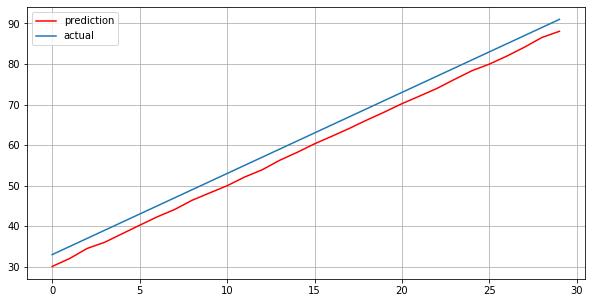

In [49]:
plt.figure(figsize=(10, 5))
plt.plot(pred_dict[:30], 'r', label="prediction")
plt.plot(y_dict[:30], label="actual")
plt.legend(loc="best")
plt.grid(True);

## Применение к реальным данным:

In [50]:
df_copy = df.copy()
df_copy

,y
Date_Time,
2016-05-26 05:00:00,1.11751
2016-05-26 06:00:00,1.11806
2016-05-26 07:00:00,1.11794
2016-05-26 08:00:00,1.11831
2016-05-26 09:00:00,1.11704
...,...
2019-02-01 19:00:00,1.14683
2019-02-01 20:00:00,1.14597
2019-02-01 21:00:00,1.14593


In [51]:
delta_in = 24
df_sample = fun_delta(df_copy, delta_in)
n_rows = 12# - число сток обучения
n_max = 168 # - ограничение расстояния движения окна предсказаний

Wall time: 46 s


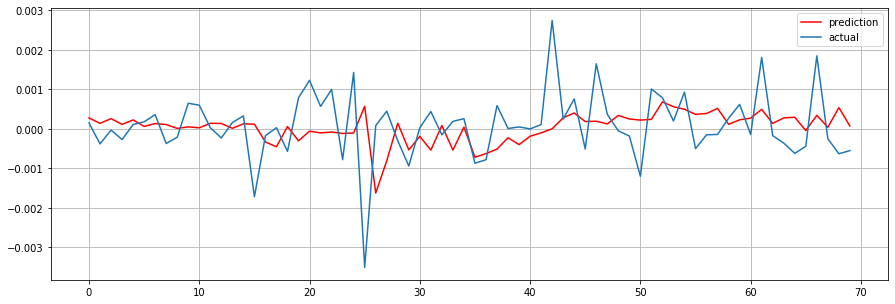

In [52]:
%%time

model = RandomForestRegressor(random_state=0)
pred_dict, y_dict = fun_slick(df_sample, model, n_rows, n_max)

plt.figure(figsize=(15, 5))
plt.plot(pred_dict[20:90], 'r', label="prediction")
plt.plot(y_dict[20:90], label="actual")
plt.legend(loc="best")
plt.grid(True);

Wall time: 30.9 s


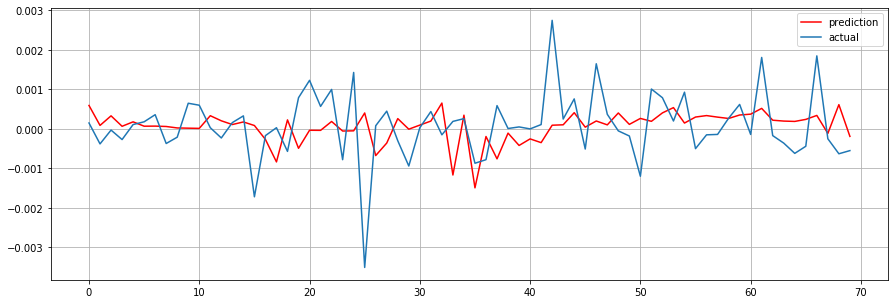

In [53]:
%%time

model = ExtraTreesRegressor(random_state=0)
pred_dict, y_dict = fun_slick(df_sample, model, n_rows, n_max)

plt.figure(figsize=(15, 5))
plt.plot(pred_dict[20:90], 'r', label="prediction")
plt.plot(y_dict[20:90], label="actual")
plt.legend(loc="best")
plt.grid(True);

Wall time: 31.8 s


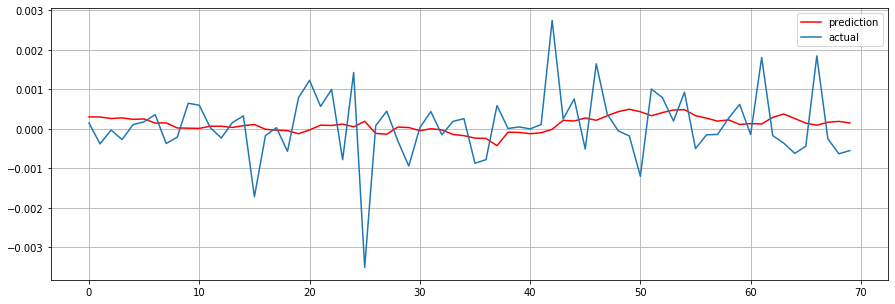

In [54]:
%%time

model = HistGradientBoostingRegressor(random_state=0)
pred_dict, y_dict = fun_slick(df_sample, model, n_rows, n_max)

plt.figure(figsize=(15, 5))
plt.plot(pred_dict[20:90], 'r', label="prediction")
plt.plot(y_dict[20:90], label="actual")
plt.legend(loc="best")
plt.grid(True);

In [55]:
%%time

model = xgboost.XGBRegressor(random_state=0)
pred_dict, y_dict = fun_slick(df_sample, model, n_rows, n_max)



[17:44:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:44:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:44:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:44:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:44:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:44:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:44:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:44:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:44:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[17:44:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:44:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:44:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:44:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:44:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:44:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:44:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:44:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:44:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

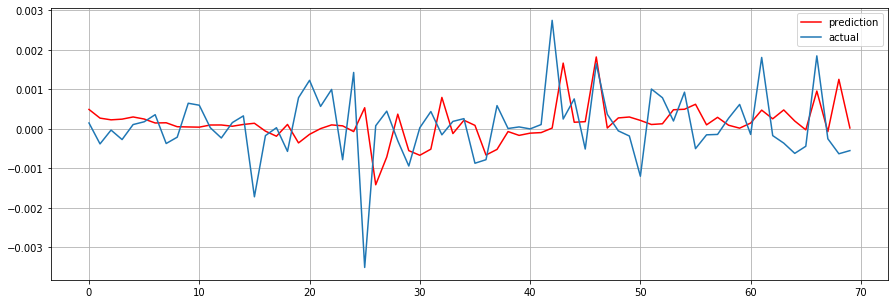

In [56]:
plt.figure(figsize=(15, 5))
plt.plot(pred_dict[20:90], 'r', label="prediction")
plt.plot(y_dict[20:90], label="actual")
plt.legend(loc="best")
plt.grid(True);

Wall time: 1.28 s


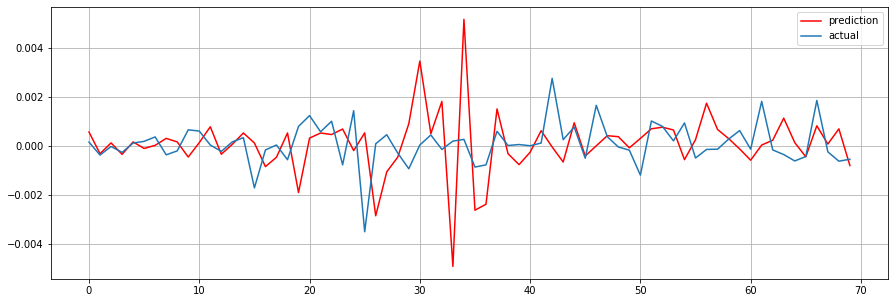

In [57]:
%%time

model = LinearRegression()
pred_dict, y_dict = fun_slick(df_sample, model, n_rows, n_max)

plt.figure(figsize=(15, 5))
plt.plot(pred_dict[20:90], 'r', label="prediction")
plt.plot(y_dict[20:90], label="actual")
plt.legend(loc="best")
plt.grid(True);

# Выводы:

Применение метода скользящего окна позволяет обучать модель актуальной информации, забывая о прошлом.
Дальнейшее улучшение этого направления:
- назначение весов лагам(дельтами) по мере их временного отдаления от прогнозируемой точки
- применение дробного дифференцирования
- подбор оптимального окна обучения
- подбор модели
- подбор параметров модели.
- и много другого

В процессе подготовки изучено много материала, спасибо группе)))
Доп.информация:



https://www.researchgate.net/publication/326977706_Primenenie_specializirovannyh_komputernyh_programm_i_metodov_osnovannyh_na_necetkih_vremennyh_radah_dla_kratkosrocnogo_prognozirovania_USDRUB_kotirovok
http://www.machinelearning.ru/wiki/index.php?title=%D0%9F%D1%80%D0%BE%D0%B3%D0%BD%D0%BE%D0%B7%D0%B8%D1%80%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5_%D0%B2%D1%80%D0%B5%D0%BC%D0%B5%D0%BD%D0%BD%D1%8B%D1%85_%D1%80%D1%8F%D0%B4%D0%BE%D0%B2_%D0%BC%D0%B5%D1%82%D0%BE%D0%B4%D0%BE%D0%BC_SSA_%28%D0%BF%D1%80%D0%B8%D0%BC%D0%B5%D1%80%29
https://habr.com/ru/post/180409/
https://habr.com/ru/post/210530/
https://habr.com/ru/post/207160/
https://habr.com/ru/company/ods/blog/327242/
http://francescopochetti.com/pythonic-cross-validation-time-series-pandas-scikit-learn/
https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-15-276
https://www.statsmodels.org/stable/index.html
https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAXResults.predict.html
